# Practical 5 - Dimensionality Reduction with PCA and t-SNE

* Names: Debwashis Borman, Navya Anantha Lakshmi Saginala, Theint Hay Thi Maung
* Summer Term 2023    
* Due Date: Tuesday, June 27, 2pm

In this practical we will implement dimensionality reduction with PCA, followed by t-SNE. Following is going to be the outline:

 1. Imports
 2. Loading data and related transformations 
 3. PCA without sklearn 
 4. PCA with sklearn and comparison with 3. 
 5. t-SNE with sklearn 

You will be plotting relevant results for viusalization and understanding as you go through the objectives. 

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(context='talk',style='white',palette='colorblind')
import pickle
import matplotlib
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import scipy as sp

## Task 0: Load and normalize count data

This practical uses the data set from https://www.nature.com/articles/s41586-018-0654-5. This is single cell transcriptomics data from ~25,000 cells from the cortex. 

For each of these cells, the expression of several thousand genes was measured ```['counts']```. In the original study, the authors were interested in clustering the cells into types. 

We made a selection of 5000 cells and the 1000 most informative genes for run time reasons. We provide you with the original cell type labels determined by the authors for comparison ```['clusters']```.

The following function will apply some preprocessing steps that are standard for transcriptomics data. We normalize the data to bring columns to comparable sizes and log-transform them as they contain huge outliers.

In [17]:
def lognormalize_counts(tasic_dict):

    # normalize and logtransform counts
    counts = tasic_dict['counts']
    libsizes = counts.sum(axis=1)
    CPM = counts / libsizes * 1e+6
    logCPM = np.log2(CPM + 1)
    tasic_dict['logCPM'] = np.array(logCPM)

    return tasic_dict

In [18]:
tasic_1k = lognormalize_counts(pickle.load(open('tasic_subset_1kselected.pickle', 'rb')))

C:\Users\Debwashis\AppData\Local\Temp\ipykernel_19904\1416081971.py:1: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  tasic_1k = lognormalize_counts(pickle.load(open('tasic_subset_1kselected.pickle', 'rb')))


Have a look at ```['counts']```, ```['logPCM']``` and ```['clusters']``` to get a better understanding of the data. Plot a histogram of the cell type labels provided by  ```['clusters']```.

In [19]:
# Explore data
print("Keys in the dictionary: ", tasic_1k.keys())

#shape of 'counts', 'logCPM', and 'clusters'
print("Shape of 'counts': ", tasic_1k['counts'].shape)
print("Shape of 'logCPM': ", tasic_1k['logCPM'].shape)
print("Shape of 'clusters': ", tasic_1k['clusters'].shape)

#few elements of 'counts', 'logCPM', and 'clusters'
print("First few elements of 'counts':\n", tasic_1k['counts'][:2])
print("First few elements of 'logCPM':\n", tasic_1k['logCPM'][:5])
print("First few elements of 'clusters':\n", tasic_1k['clusters'][:5])

Keys in the dictionary:  dict_keys(['counts', 'genes', 'clusters', 'areas', 'clusterColors', 'clusterNames', 'logCPM'])
Shape of 'counts':  (5000, 1000)
Shape of 'logCPM':  (5000, 1000)
Shape of 'clusters':  (5000,)
First few elements of 'counts':
   (1, 4)	176.0
  (0, 4)	650.0
  (1, 12)	453.0
  (0, 12)	1060.0
  (0, 25)	1.0
  (0, 26)	1.0
  (1, 29)	772.0
  (0, 29)	1574.0
  (1, 34)	103.0
  (0, 34)	268.0
  (1, 36)	146.0
  (0, 36)	1.0
  (0, 45)	277.0
  (1, 53)	204.0
  (0, 53)	193.0
  (1, 61)	70.0
  (0, 61)	13.0
  (1, 67)	591.0
  (0, 67)	1693.0
  (1, 69)	206.0
  (0, 69)	23.0
  (1, 73)	261.0
  (0, 73)	414.0
  (1, 80)	159.0
  (0, 80)	3286.0
  :	:
  (0, 958)	15.0
  (1, 959)	1295.0
  (0, 959)	2498.0
  (1, 961)	1144.0
  (0, 961)	1817.0
  (1, 962)	632.0
  (0, 962)	2092.0
  (1, 963)	769.0
  (0, 963)	1616.0
  (1, 968)	989.0
  (0, 968)	2196.0
  (0, 979)	26.0
  (0, 980)	1.0
  (1, 981)	656.0
  (0, 981)	1436.0
  (1, 982)	152.0
  (0, 982)	1253.0
  (1, 989)	2453.0
  (0, 989)	3681.0
  (0, 990)	8.0
  (1, 9

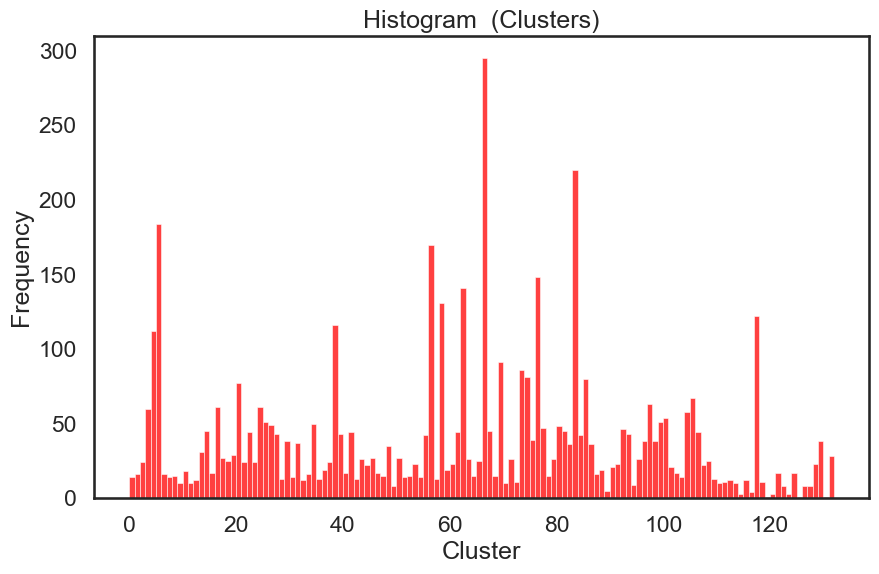

In [20]:
# Plotting  (clusters)
plt.figure(figsize=(10,6))
sns.histplot(tasic_1k['clusters'], bins=np.arange(tasic_1k['clusters'].min(), tasic_1k['clusters'].max()+1), kde=False, color='red')
plt.title('Histogram  (Clusters)')
plt.xlabel('Cluster')
plt.ylabel('Frequency')
plt.show()

## Task 1: Linear dimensionality reduction with PCA

In this task, you will use Principal Component Analysis (PCA) to reduce the dimensionality of the dataset.

First, implement PCA "by hand". You can use eigenvalue/singular value decomposition from numpy/scipy but no `sklearn`-functions. Write a function that computes all possible principal components and returns them along with the fraction of variance they explain.

In [21]:
def PCA_manual(data):
    '''
    Function that performs PCA on the input data
    
    input: (cells, genes)-shaped array of log transformed cell counts
    output:
        fraction_variance_explained: (genes,)-shaped array with the fraction of variance explained by the individual PCs
        principal_components: (genes, genes)-shaped array containing the principal components as columns
    '''
     ### NOTE: Make sure the function returns the PCs sorted by the fraction of variance explained! ###
    ###       (First column of principal_components should hold the PC with the highest variance   ###
    ###       explained -- fraction_variance_explained should also be sorted accordingly)          ###
    ###       Also remember to center your columns by substracting the mean of each column before  ###
    ###       you calculate the covariance matrix to get the principal components.                 ###

    # ---------------- INSERT CODE ----------------------
    
    means = np.mean(data,axis=0)
    
    data-=means     # centering 
    #print(data.shape)
    S = np.cov(data.T)# along the axis of the feature space bumms
    
    
    V = 0
    for i in range(len(S)):
        V += S[i,i]
    u,s,vh = np.linalg.svd(data,full_matrices = True) #,hermitian = True)   
    w = s**2
    
    principal_components = vh.T
    fraction_variance_explained = w/(data.shape[0]-1)/V

    
    return fraction_variance_explained, principal_components


In [22]:
var_expl, PCs = PCA_manual(tasic_1k['logCPM'])

Before we explore the structure of the low-dimensional representation, we first want to know how much variance the first PCs explain: 

- Plot the fraction of variance explained by the `n`-th PC vs. `n`

- Plot the cumulative fraction of variance explained by the first `n` PCs with largest eigenvalue vs. `n`

From the latter plot you should be able to see how many PCs you need to keep to explain at least `x`% of the variance.

How many components do you need to keep to explain 50%, 75%, 90% and 99%, respectively? Indicate this in your plot.

YOUR ANSWER HERE

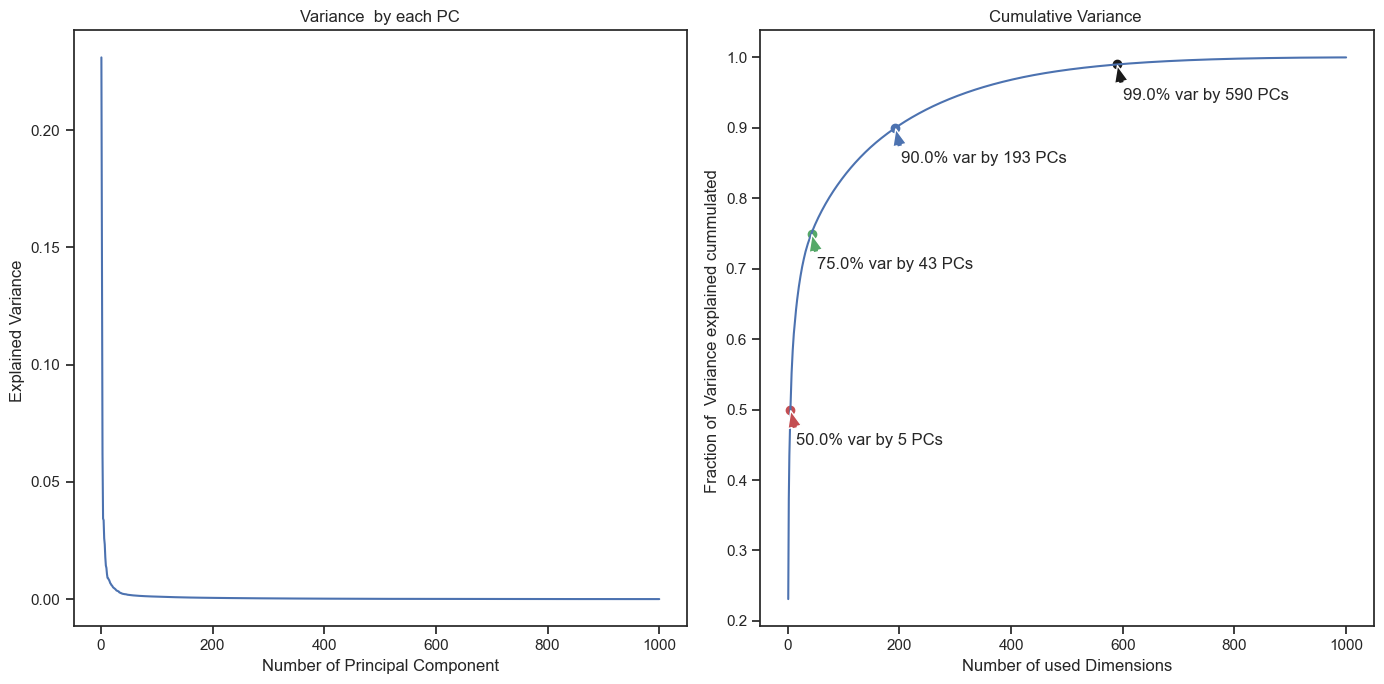

In [37]:
n_PCs = len(var_expl)
PC_ids = np.arange(1, n_PCs+1)

plt.figure(figsize=(14, 7))

plt.subplot(121)

# Plot the variance explained of the n-th PC vs. n
# ---------------- INSERT CODE ----------------------

plt.plot(PC_ids, var_expl)
plt.title('Variance  by each PC')
plt.xlabel('Number of Principal Component')
plt.ylabel('Explained Variance ')

# ---------------- END CODE -------------------------

plt.subplot(122)

# Plot the cumulative variance explained for the n PCs with highest variance explained vs. n
# Indicate how many components you need to keep to explain 50%, 75%, 90% and 99% in the plot.

# ---------------- INSERT CODE ----------------------
cumulative_var_expl = np.cumsum(var_expl)
plt.plot(PC_ids, cumulative_var_expl)
thresholds = [0.5, 0.75, 0.9, 0.99]
colors = ['r', 'g', 'b', 'k']
for threshold, color in zip(thresholds, colors):
    n_components = np.argmax(cumulative_var_expl >= threshold) + 1
    plt.scatter(n_components, threshold, color=color)
    plt.annotate(f'{threshold*100}% var by {n_components} PCs', xy=(n_components, threshold), 
                 xytext=(n_components+10, threshold-0.05), 
                 arrowprops=dict(facecolor=color, shrink=0.05, headwidth=10))

plt.title('Cumulative Variance ')
plt.xlabel('Number of used Dimensions')
plt.ylabel('Fraction of  Variance explained cummulated ')

plt.tight_layout()
plt.show()

# ---------------- END CODE -------------------------

Write a function to select the `n` PCs needed to explain at least `x`% of the variance and use this function to extract as many PCs as are needed to explain 75% of the variance. 

In [24]:
def select_PCs(
    variance_explained, principal_components, percent_variance=None):
    '''Function that selects the first n principal components necessary to explain x% of the variance
    input: 
        variance_explained: amount of variance explained by the individual PCs
        principal_components: contains the principal components as columns
        percent_variance: fraction of the variance, the all PCs that are kept explain
    output:
        variance_explained_kept: individual amount of variance explained for the remaining PCs
        principal_components_kept: remaining principal components, shape (genes,n_PCs_kept)
                
    '''
  
    # ---------------- INSERT CODE ----------------------
    sum = 0
    min = 0
    for i in range(len(variance_explained)):
        sum += variance_explained[i]
        if sum >= percent_variance:
            min = i
            break
    variance_explained_kept = variance_explained[:min+1]
    principal_components_kept = principal_components[:min+1]
    
    
    # ---------------- END CODE -------------------------
            
    return variance_explained_kept, principal_components_kept

In [25]:
_, PCs75 = select_PCs(var_expl, PCs, percent_variance=0.75)


To compute the representation of the data in this lower dimensional representation, write a function that compute the PC scores for each cell, i.e. that projects the original data matrix on the low-dimensional subspace provided by the first `n` PCs:

In [26]:
def compute_PCA_scores(data, principal_components):
    '''Function that returns the PC scores for each data point
    input: 
        data                 --- (cells,genes)-shaped array of log transformed cell counts
        principal_components --- contains the principal components as columns\
    output:
        pc_scores            --- (cells,n_PCs_kept)-shaped array of PC scores
    
    ''' 
    
    # ---------------- INSERT CODE ----------------------
    pc_scores = data@principal_components.T
    #print(data.shape)
    #print(principal_components.shape)
    #print(pc_scores)
    
    # ---------------- END CODE -------------------------

    return pc_scores

In [27]:
tasic_1k['PCA_75'] = compute_PCA_scores(tasic_1k['logCPM'], PCs75)


Visualize the top 5 PCs as a pairwise scatterplot. Use one subplot for each pair of components.

Use the colors provided in `tasic_1k['clusterColors']` and the cluster information in `tasic_1k['clusters']` to color each data point according to its original cluster identity.

The colors indicate the family of the cell type:

- greenish colors: excitatory neurons
- orange colors: somatostatin positive interneurons
- pinkish colors: VIP-postive interneurons
- reddish colors: parvalbumin positive interneurons
- dark colors: non-neurons (glia etc)

What do you observe?

In [28]:
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import pandas as pd

def plot_PCs(data_transformed, color_per_datapoint):
    '''Function that plots the scores of the 10 pairs of the top 5 PCs against each other.
        inputs:
            data_transformed    -- (cells,n_PCs_kept)-shaped array of PC scores
            color_per_datapoint -- (cells,)-shaped array of color strings, one color for each cell
    '''
   
    
    # ---------------- INSERT CODE ----------------------
    plt.figure(figsize=(20, 20))
    for i in range(5):
            for j in range(i+1, 5):
                plt.subplot(5, 5, i*5+j+1)
                plt.scatter(data_transformed[:, i], data_transformed[:, j], c=color_per_datapoint, s=20)
                plt.xlabel(f'PC{i+1}')
                plt.ylabel(f'PC{j+1}')
                
    plt.tight_layout()
    plt.show()
    #return pandabeer
    # ---------------- END CODE -------------------------

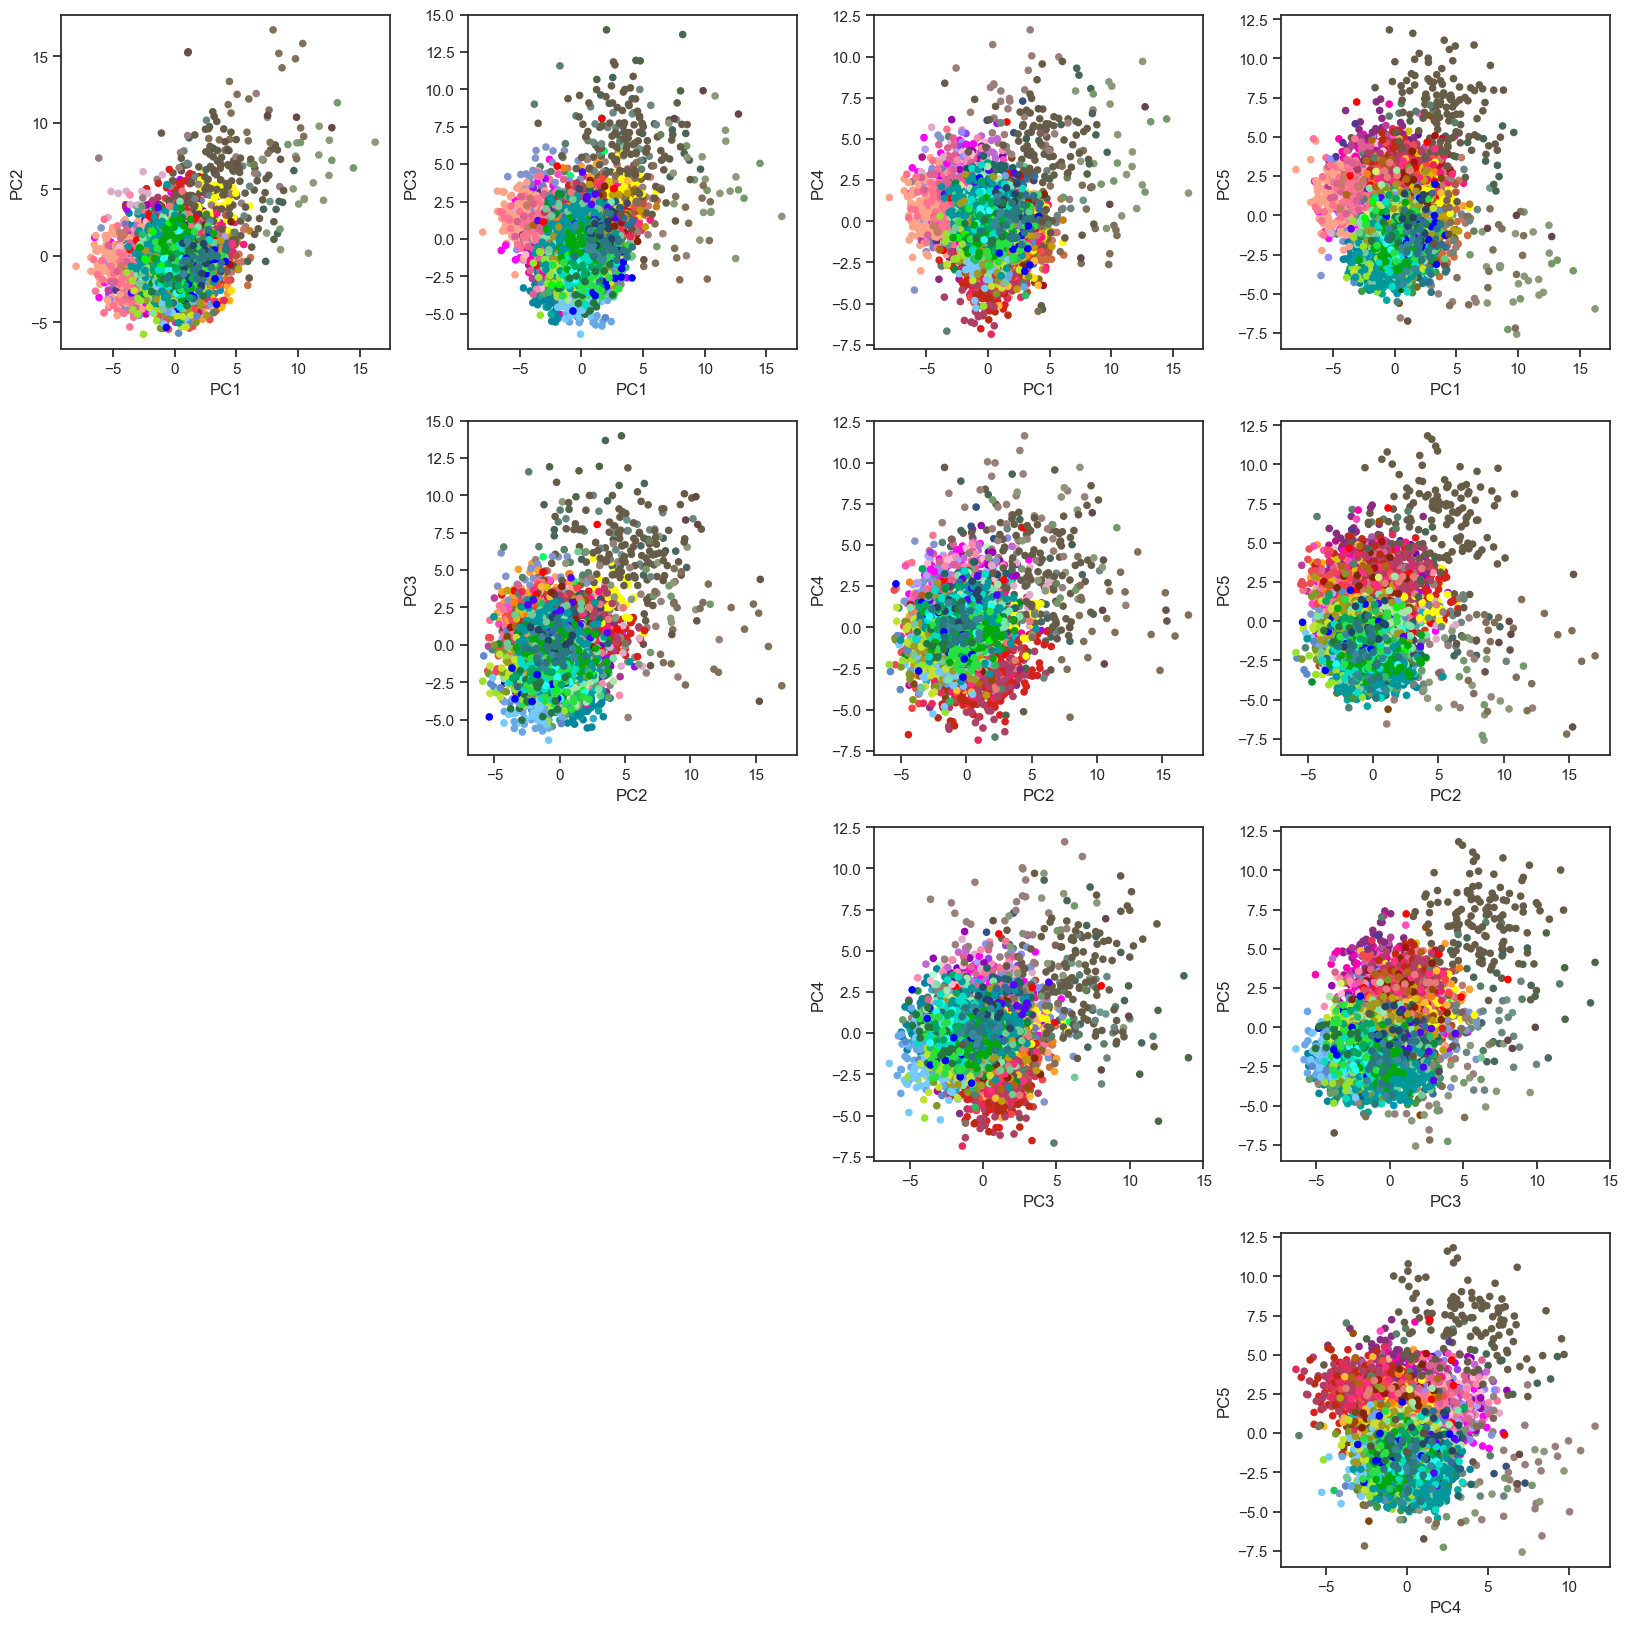

In [29]:
color_per_datapoint = tasic_1k['clusterColors'][tasic_1k['clusters']]
plot_PCs(tasic_1k['PCA_75'], color_per_datapoint)

Points of the same color are grouped together and separate from points of other colors mostly, so it can be said that classes can be separated.

## Task 2: Comparison with PCA implemented by sklearn

Use the PCA implementation of sklearn to check whether your PCA implementation is correct and obtain some insights into numerical precision of the algorithms underlying PCA implementations. Note that the sklearn implementation of PCA switches the dimensions of the matrix, so you will have to transpose your principal components matrix to get the same output as in the manual implementation.

In [30]:
def PCA_sklearn(data):
    '''
    Function that performs PCA on the input data, using sklearn
    
    input: (cells,genes)-shaped array of log transformed cell counts
    output:
        fraction_variance_explained: (genes,)-shaped array with the fraction of variance explained by the individual PCs
        principal_components: (genes,genes)-shaped array containing the principal components as columns
    '''

    # ---------------- INSERT CODE ----------------------
    pca = PCA()
    pca.fit(data)
    #print(reduced_data)
    fraction_variance_explained = pca.explained_variance_ratio_
    principal_components = pca.components_
    
    
    # ---------------- END CODE -------------------------
    
    return fraction_variance_explained, principal_components

In [31]:
# do sklearn-PCA on selected genes
var_expl_sklearn, PCs_sklearn = PCA_sklearn(tasic_1k['logCPM'])
# select components as before
_, PCs_sklearn75 = select_PCs(var_expl_sklearn, PCs_sklearn, 0.75)
# get PC scores
PCA_75_sklearn = compute_PCA_scores(tasic_1k['logCPM'], PCs_sklearn75)

To see if your manual PCA yielded the same PC weights as the sklearn PCA, we can just take the two matrices of principal components and plot their entries against each other. (Note: This again assumes they are sorted by variance explained and the order of dimensions in your weight matrix compared to the sklearn weight matrix is the same (change if necessary).)

Use the following plot to compare the results to your own implementation (here plotting the weights of the first 100 PCs against each other). What do you observe?

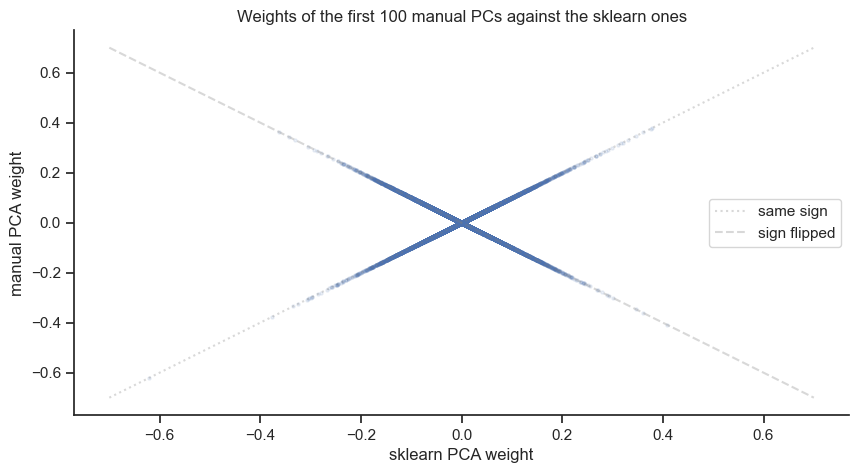

In [36]:
n_evs_to_compare = 100
PCs = PCs.T# transpose to get the same shape as sklearn PCs
plt.figure(figsize=(10, 5))
plt.scatter(PCs_sklearn[:, :n_evs_to_compare].flatten(),
            PCs[:, :n_evs_to_compare].flatten(), s=5, alpha=0.1)
plt.plot([-.7, .7], [-.7, .7], ':', c='tab:gray', label='same sign', alpha=0.3)
plt.plot([-.7, .7], [.7, -.7], '--', c='tab:gray', label='sign flipped', alpha=0.3)
plt.legend()
plt.xlabel('sklearn PCA weight')
plt.ylabel('manual PCA weight')
plt.title('Weights of the first %u manual PCs against the sklearn ones' % (n_evs_to_compare))

sns.despine()

Sklearn also produces correct results but partially reverses the direction of the eigenvectors

Additional reading about the sign of PCs: https://stats.stackexchange.com/questions/88880/does-the-sign-of-scores-or-of-loadings-in-pca-or-fa-have-a-meaning-may-i-revers

## Task 3: Nonlinear dimensionality reduction with t-SNE

In this task, you will use the nonlinear dimensionality reduction technique tSNE and look at visualizations of the data set. Plot the result of default t-SNE with the original cluster colors. For this and the following tasks, use the PCs explaining 75% of the variance ```PCA_75_sklearn``` you computed above.

In [20]:
def plot_tsne(tsne_results, clusters=tasic_1k['clusters'], labels=['']):
    '''Plotting function for tsne results, creates one or multiple plots of tSNE-transformed data.
       If the clustering is the original one (default), original cluster colors will be used. Otherwise,
       colors will be a random permutation.

    input:
        tsne_results: (n, 2)-shaped array containing tSNE-transformed data or list of such arrays
                      (output of the fit_transform function of sklearn tSNE)
        clusters: (n,)-shaped array containing cluster labels or list of such arrays
        labels: optional, list of titles for the subplots
    '''

    if type(tsne_results) == list:  # make sure we can do both single and multiple plots and are flexible regarding input
        num_plots = len(tsne_results)
    else:
        num_plots = 1
        tsne_results = [tsne_results]
    if type(clusters) == list:
        num_clusters = len(clusters)
        num_plots = num_plots * num_clusters
        tsne_results = tsne_results * num_clusters
    else:
        clusters = [clusters] * num_plots

    if len(labels) == 1:
        labels = labels * num_plots

    n_clusters = len(np.unique(clusters))      # ensure a long enough color list even if we plot more than
    n_colors = len(tasic_1k['clusterColors'])  # the original number of clusters
    if n_clusters > n_colors:
        n_extra_colors = n_clusters - n_colors
        colors = np.concatenate((tasic_1k['clusterColors'], tasic_1k['clusterColors'][:n_extra_colors]))
    else:
        colors = tasic_1k['clusterColors']

    fig, ax = plt.subplots(num_plots, 1, figsize=(10, num_plots*10))
    if num_plots == 1:
        if not np.all(tasic_1k['clusters'] == clusters[0]):
            current_colors = np.random.permutation(colors)
        else:
            current_colors = colors
        ax.scatter(tsne_results[0][:, 0], tsne_results[0][:, 1], s=1, color=current_colors[clusters[0]])
        ax.set_title(labels[0])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_axis_off()
    else:
        for i in range(num_plots):
            if not np.all(tasic_1k['clusters'] == clusters[i]):
                current_colors = np.random.permutation(colors)
            else:
                current_colors = colors
            ax[i].scatter(tsne_results[i][:, 0], tsne_results[i][:, 1], s=1, color=current_colors[clusters[i]])
            ax[i].set_title(labels[i])
            ax[i].set_xticks([])
            ax[i].set_yticks([])
            ax[i].set_axis_off()

Run the following cells to set the random seed/random state, run tSNE and plot the results.

In [21]:
# fit TSNE
tsne_default = TSNE(random_state=1)
tsne_results = tsne_default.fit_transform(PCA_75_sklearn)

c:\Python\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


C:\Users\Debwashis\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


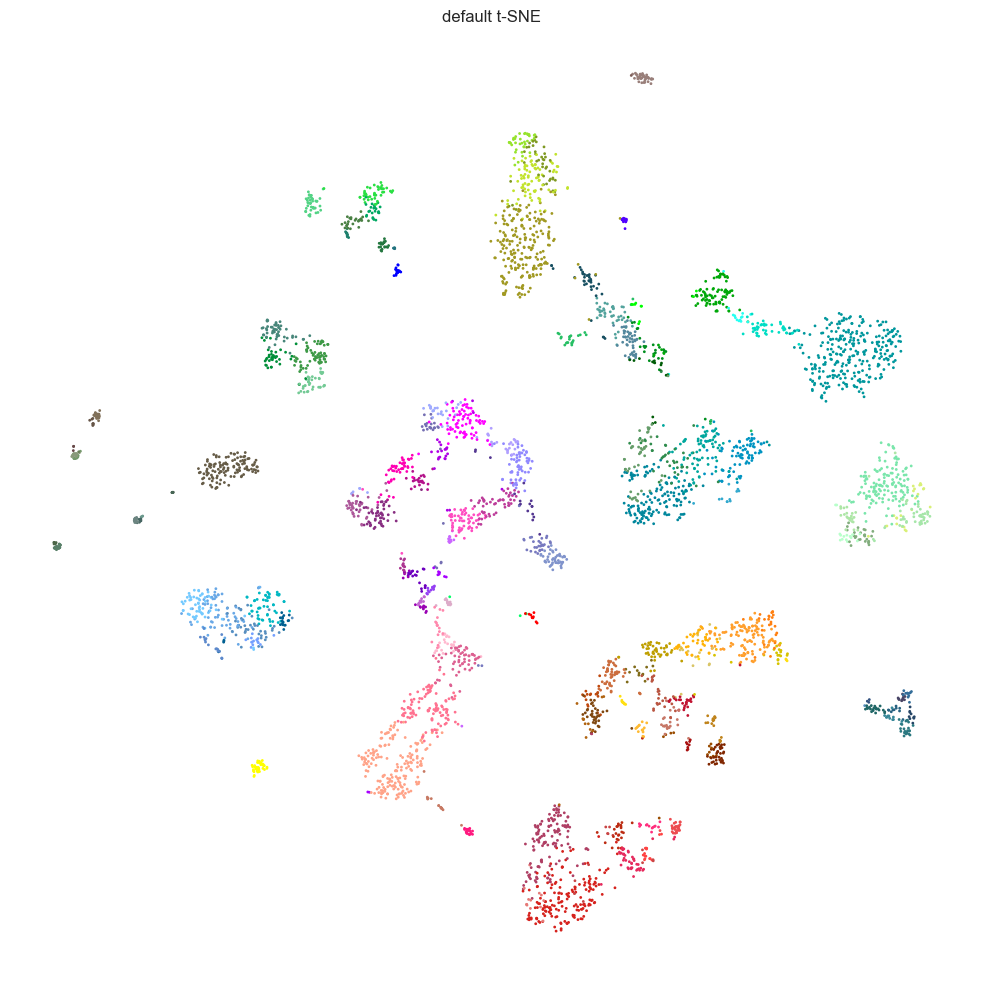

In [22]:
# Plotting

original_clusters = tasic_1k['clusters']
plot_tsne(tsne_results, original_clusters, labels=['default t-SNE'])

t-SNE has one main parameter called perplexity, which trades of local and global structure. Its default value is 30. Run the tSNE with some other perplexity values (e.g. 5, 100), plot the results next to each other and explain what you observe. In particular, compare with the PCA plot above.

c:\Python\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\Debwashis\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


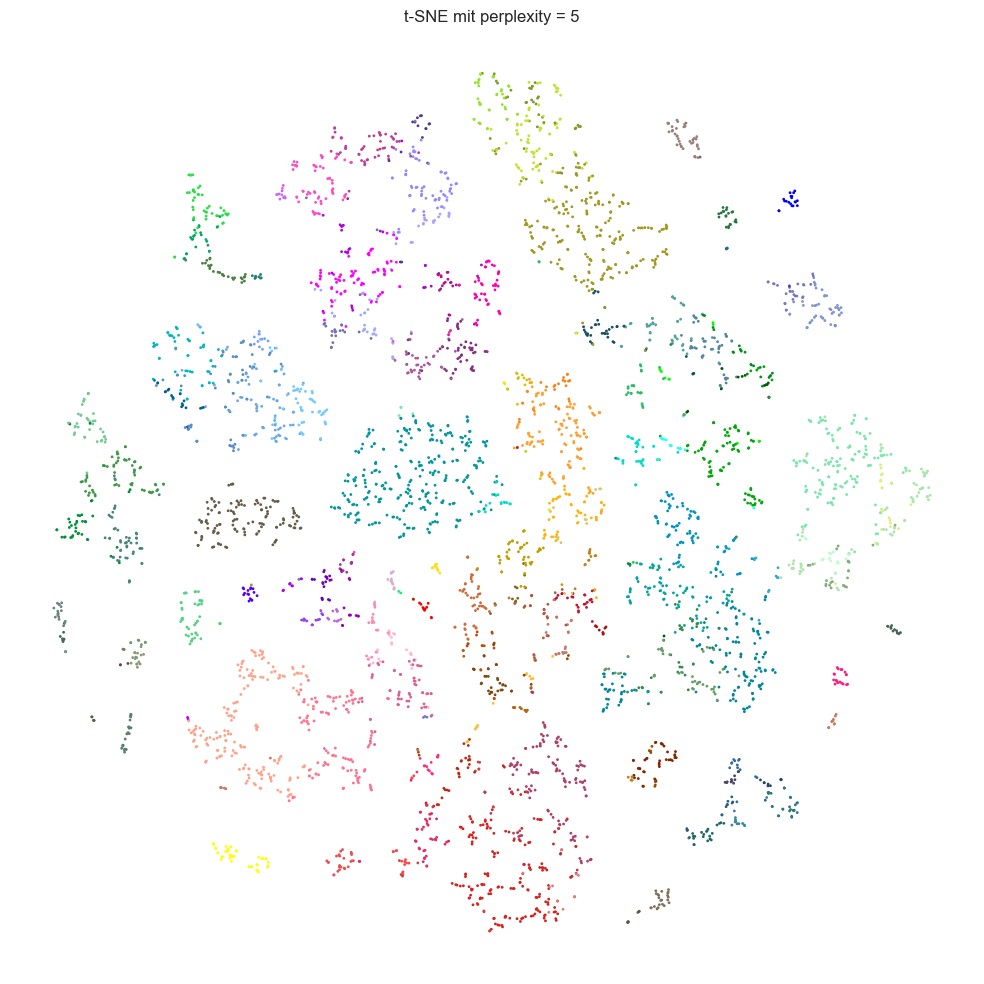

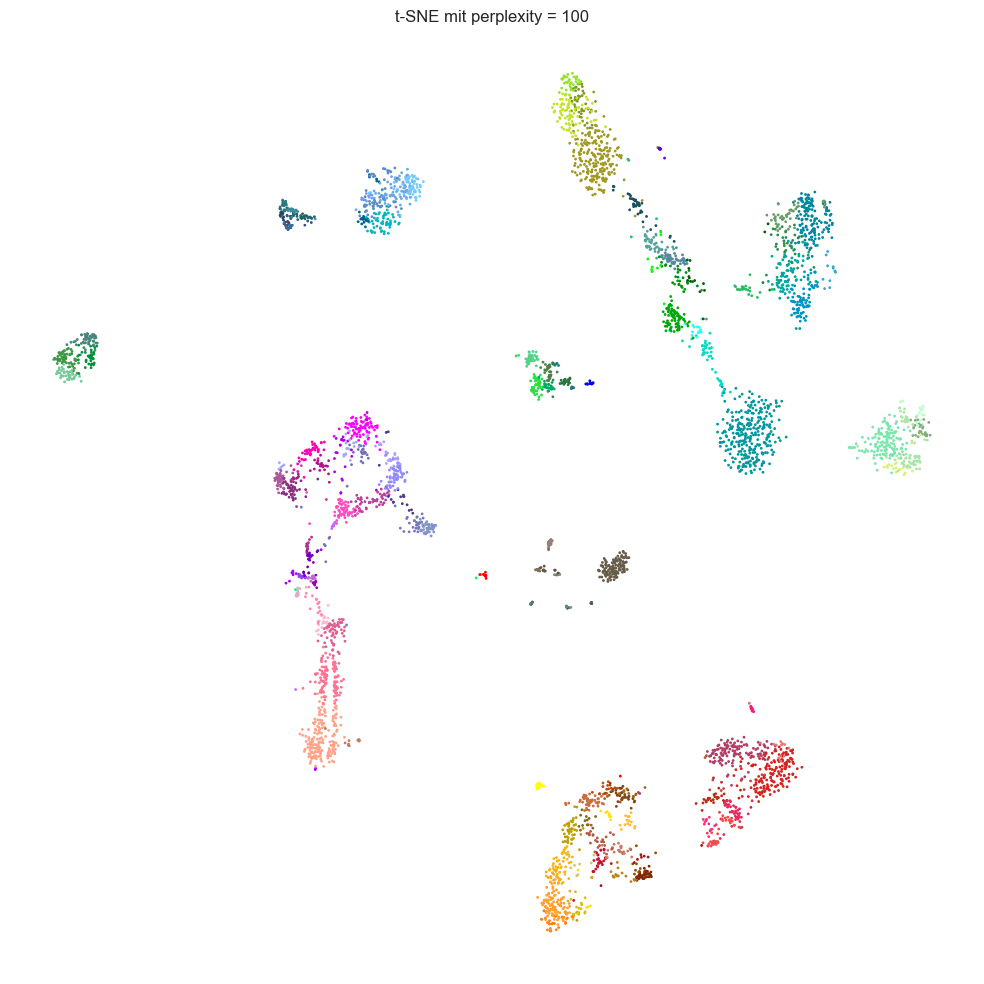

In [23]:
# try different perplexities

# ---------------- INSERT CODE ----------------------

perplexities = [5,100]
    
for i in perplexities:
    tsne_default = TSNE(random_state=1,perplexity = i)
    tsne_results = tsne_default.fit_transform(PCA_75_sklearn)
    original_clusters = tasic_1k['clusters']
    plot_tsne(tsne_results, original_clusters, labels=['t-SNE mit perplexity = '+str(i)])

# ---------------- END CODE -------------------------

YOUR ANSWER HERE

Check out https://distill.pub/2016/misread-tsne/. There's a nice tool that let's you play with t-SNE paramters and visualize the consequences.